<a href="https://colab.research.google.com/github/Siuuuuuu0/ML-DL/blob/main/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data initialization

In [513]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import random
from sklearn.linear_model import LinearRegression

torch.__version__

'2.9.0+cpu'

In [514]:
w = 2.7
b = -6

start, end, n_samples = -5, 5, 100

X = torch.linspace(start, end, n_samples).unsqueeze(dim=1)

noise = torch.randn(n_samples, 1)*0.5
#N(0, 0.5^2)=N(0, 25)

y = w * X + b + noise

overall_results = {}

X[:5], y[:5]

(tensor([[-5.0000],
         [-4.8990],
         [-4.7980],
         [-4.6970],
         [-4.5960]]),
 tensor([[-19.1429],
         [-18.4567],
         [-18.5633],
         [-19.1123],
         [-18.1136]]))

In [515]:
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_test)

(80, 20)

In [516]:
def plot_predictions(
    train_data = X_train,
    train_labels = y_train,
    test_data = X_test,
    test_labels = y_test,
    predictions = None
):
  plt.figure(figsize=(10, 7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  plt.scatter(test_data, test_labels, c="r", s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="g", s=4, label="Predictions")

  plt.legend(prop={"size":14})



In [517]:
def plot_loss_values(epoch_count, loss_values, test_loss_values=None):
  plt.figure(figsize=(10, 7))
  plt.plot(epoch_count, loss_values, label="Train loss")
  plt.plot(epoch_count, test_loss_values, label="Test loss")
  plt.title("Training and test loss curves")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()

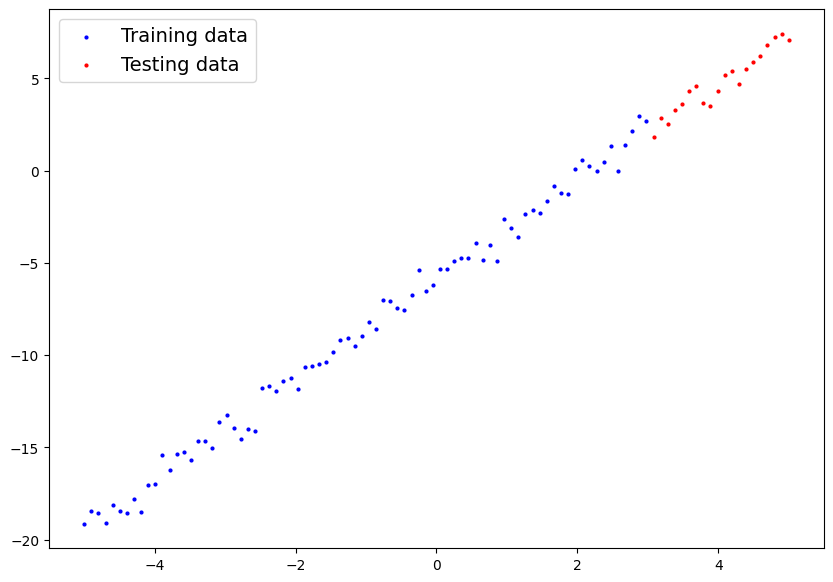

In [518]:
plot_predictions()

# Sklearn Analytical LR

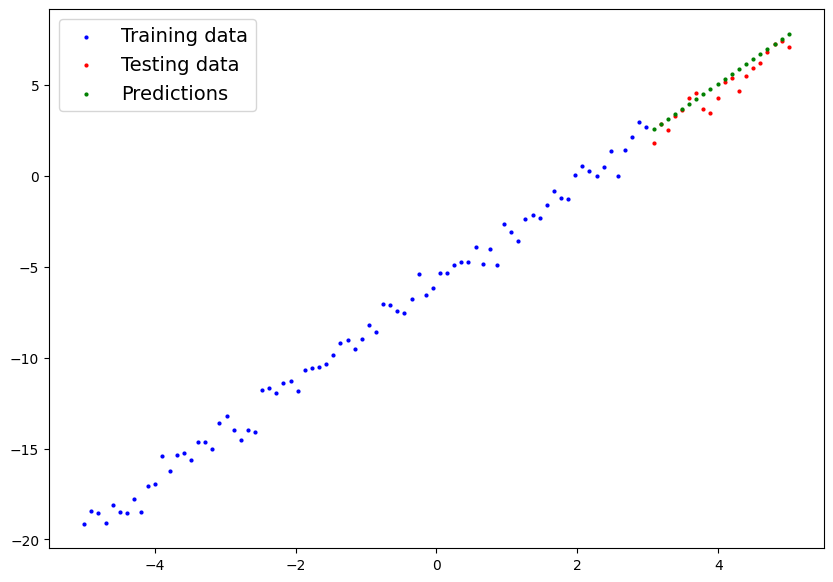

In [519]:
lr_model = LinearRegression()

lr_model.fit(X_train.detach().numpy(), y_train.detach().numpy())

w = lr_model.coef_[0][0]
b = lr_model.intercept_[0]

overall_results["Sklearn Analytical LR"] = (w, b)

plot_predictions(predictions= X_test*w+b)

# Manual Batch GD

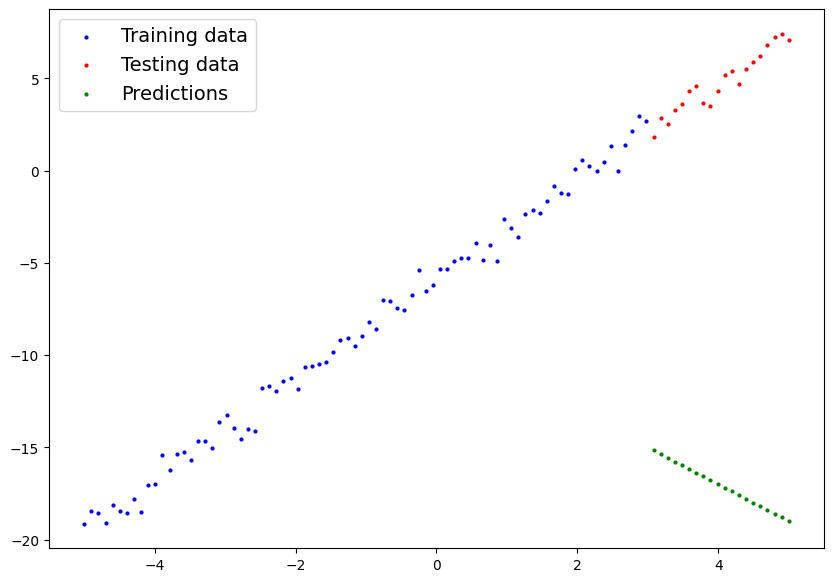

In [520]:
start_weights, start_bias = random.randrange(-10, 10), random.randrange(-10, 10)
y_preds = X_test * start_weights + start_bias
plot_predictions(predictions=y_preds)

In [521]:
def MSE_loss(y, y_pred):
  return ((y-y_pred)**2).mean()
  #mean squared error

In [522]:
def gradient_descent(X_train, y_train, y_preds):
  w = -2*(X_train*(y_train-y_preds)).mean()
  b = -2*(y_train-y_preds).mean()
  return w, b

/tmp/ipython-input-2547894404.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(prop={"size":14})


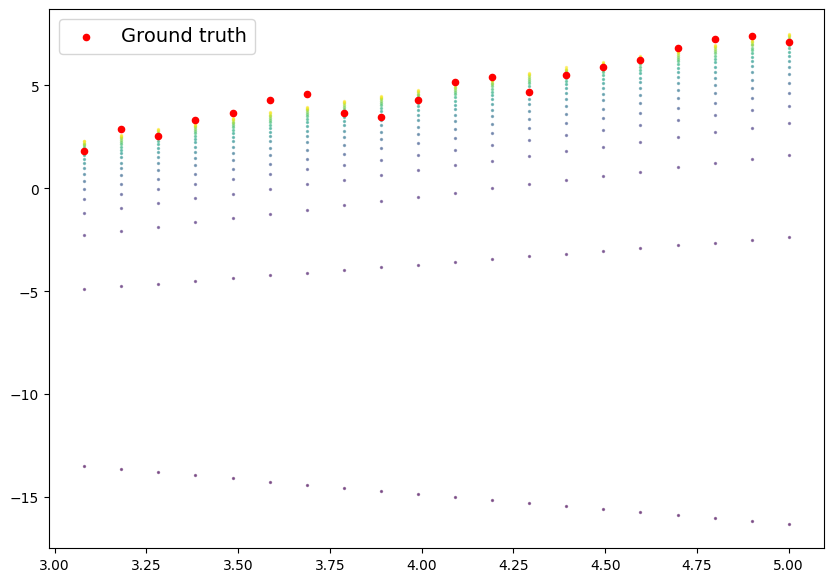

In [523]:
lr = 0.01
epochs = 200

w, b = start_weights, start_bias

loss_values = []
test_loss_values = []
epoch_count = []

plt.figure(figsize=(10, 7))

plt.legend(prop={"size":14})

colors = plt.cm.viridis(torch.linspace(0, 1, epochs//10))

for epoch in range(epochs):

  y_preds = X_train * w + b

  loss = MSE_loss(y_train, y_preds)

  dw, db = gradient_descent(X_train, y_train, y_preds)

  w, b = w - lr*dw, b - lr*db

  if(epoch%10 == 0):
    y_test_preds = X_test*w+b
    plt.scatter(X_test, y_test_preds, color=colors[epoch//10], s=2, alpha=0.5)
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(MSE_loss(y_test, y_test_preds))

plt.scatter(X_test, y_test,
            c="r", s=20, label="Ground truth")
plt.legend(prop={"size":14})

overall_results["Manual Batch GD"] = (w.detach().numpy(), b.detach().numpy())

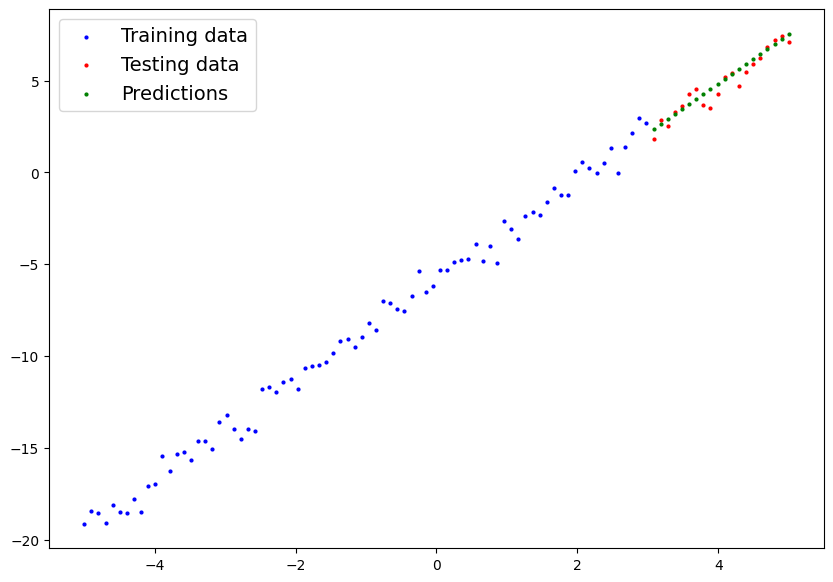

In [524]:
plot_predictions(predictions= X_test*w+b)

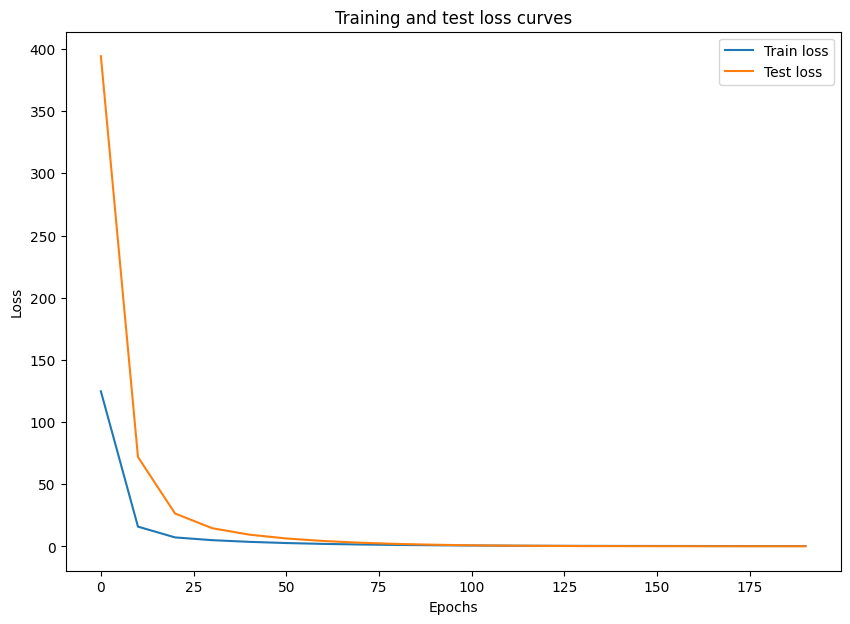

In [525]:
plot_loss_values(epoch_count, loss_values, test_loss_values)

# PyTorch Batch GD

In [526]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(
        torch.randn(1,
                    requires_grad=True,
                    dtype=torch.float)
    )
    self.bias = nn.Parameter(
        torch.randn(1,
            requires_grad = True,
            dtype = torch.float
        )
    )

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

In [527]:
torch.manual_seed(52)

model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([-0.1455], requires_grad=True),
 Parameter containing:
 tensor([-1.1507], requires_grad=True)]

In [528]:
model_0.state_dict()

OrderedDict([('weights', tensor([-0.1455])), ('bias', tensor([-1.1507]))])

In [529]:
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds[:5]

tensor([[-1.5991],
        [-1.6138],
        [-1.6285],
        [-1.6432],
        [-1.6579]])

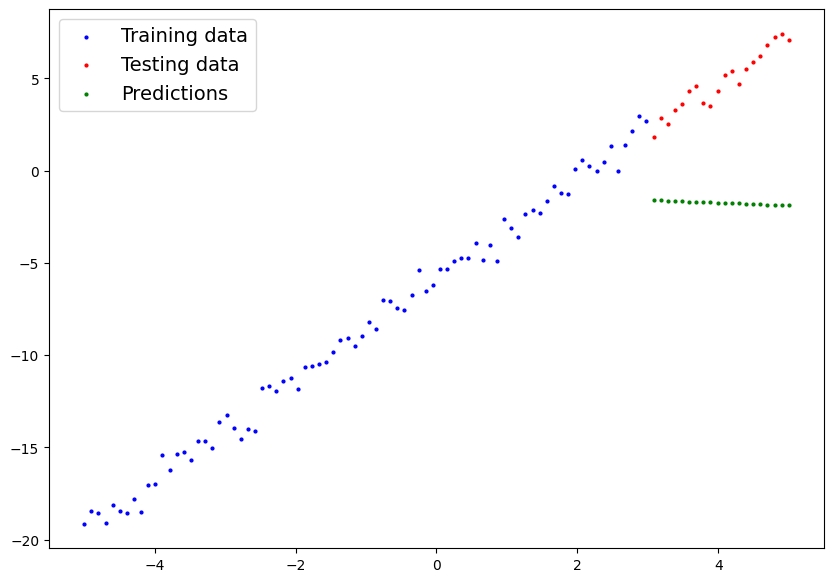

In [530]:
plot_predictions(predictions=y_preds)

In [531]:
loss_fn = nn.MSELoss()
#Работает плохо с L1Loss

optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)

/tmp/ipython-input-1941745376.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(prop={"size":14})


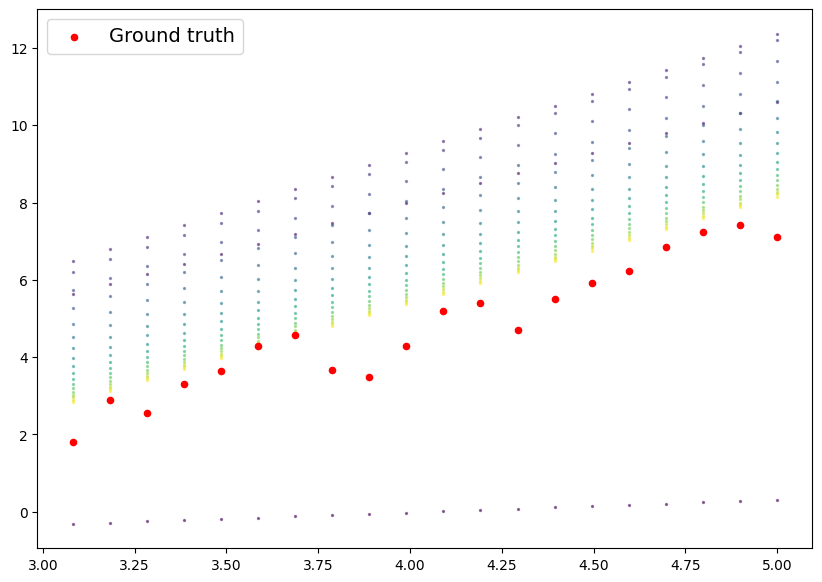

In [532]:
epochs = 200

loss_values = []
test_loss_values = []
epoch_count = []

plt.figure(figsize=(10, 7))

plt.legend(prop={"size":14})

colors = plt.cm.viridis(torch.linspace(0, 1, epochs//10))

for epoch in range(epochs):
  model_0.train()

  y_pred = model_0(X_train)

  loss = loss_fn(y_pred, y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_0.eval()

  with torch.inference_mode():
    test_preds = model_0(X_test)
    test_loss = loss_fn(test_preds, y_test.type(torch.float))

    if(epoch%10==0):
      plt.scatter(X_test, test_preds, color=colors[epoch//10], s=2, alpha=0.5)
      epoch_count.append(epoch)
      loss_values.append(loss.detach().numpy())
      test_loss_values.append(test_loss.detach().numpy())

plt.scatter(X_test, y_test,
            c="r", s=20, label="Ground truth")
plt.legend(prop={"size":14})

weights, bias = model_0.parameters()

overall_results["Pytorch SGD"] = (weights.detach().numpy(), bias.detach().numpy())

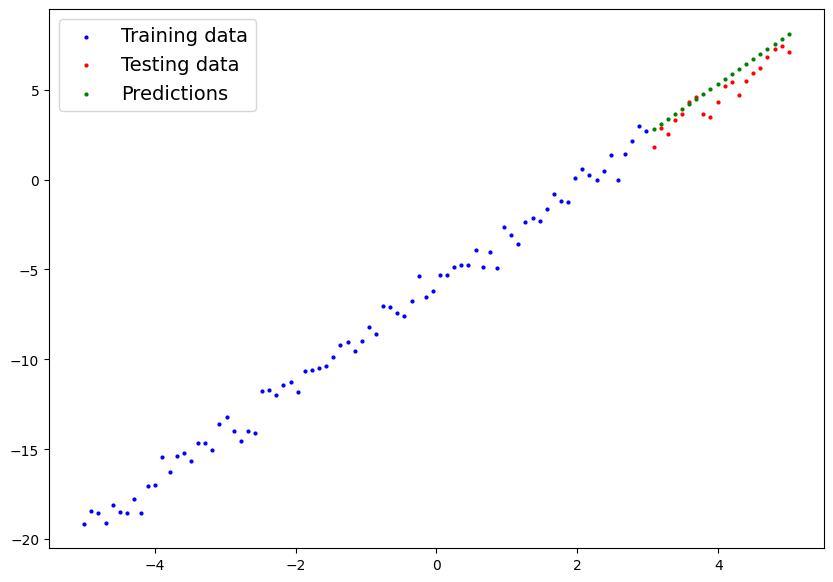

In [533]:
with torch.inference_mode():
    y_preds = model_0(X_test)
plot_predictions(predictions= y_preds)

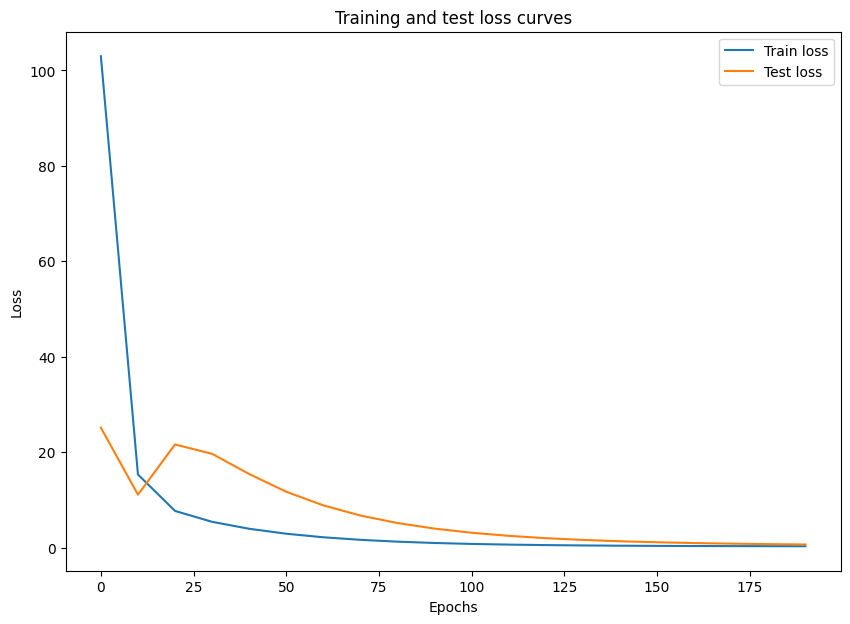

In [534]:
plot_loss_values(epoch_count, loss_values, test_loss_values)

In [535]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "Pytorch_SGD.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

# Methods Comparison

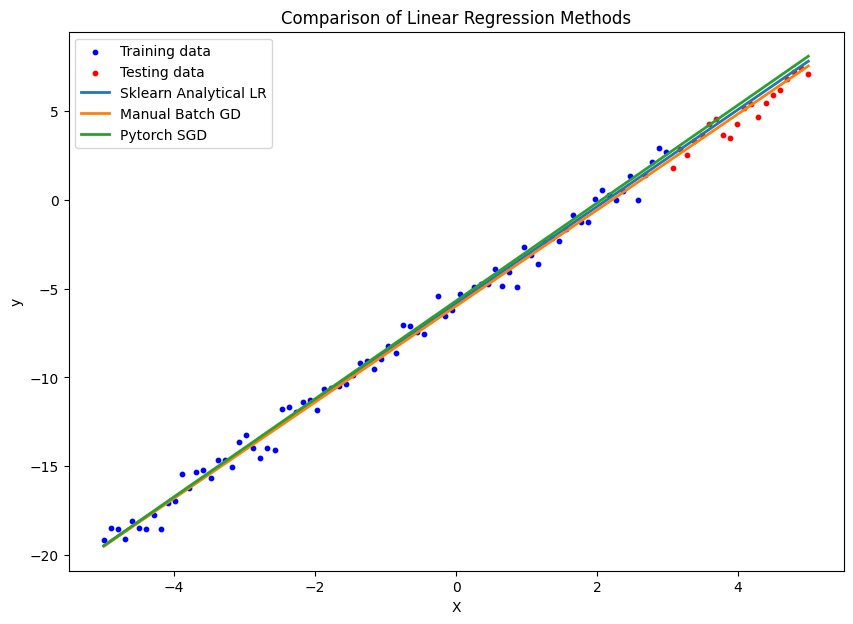

In [536]:
plt.figure(figsize=(10,7))

plt.scatter(X_train, y_train, c="blue", s=10, label="Training data")
plt.scatter(X_test, y_test, c="red", s=10, label="Testing data")

x_line = np.linspace(X.detach().numpy().min(), X.detach().numpy().max(), 100)

for method_name, (w, b) in overall_results.items():
    y_line = w * x_line + b
    plt.plot(x_line, y_line, label=method_name, linewidth=2)

plt.xlabel("X")
plt.ylabel("y")
plt.title("Comparison of Linear Regression Methods")
plt.legend()
plt.show()
